# Pagination and more Pandas

When sending a subgraph query, the number of entities that can be returned is limited. In many cases, espacially in analytics and machine learning we want access to as much data as possible. This tutorial will introduce the concepts of pagination to download larger datasets.  
  
Finally, this tutorial will also import the data to Pandas for initial analysis.

## Initial query

The first step is to use the Graph to access to up to date, indexed on-chain data. Data is accessed through subgraphs, where each subgraphs can be thought of as a database containing a specific subset of all on-chain data.  
  
Each subgraphs has its own schema, which can be found and explored through the Graph Explorer at [thegraph.com/explorer](https://thegraph.com/explorer/).  
  
The first step in any project will be to find the data of interest and then building a query for this data. The following is an example using the Uniswap v2 subgraph to access ether price data.  

In [83]:
# step 0, some imports that will be used in this example
import requests
import json
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

In [84]:
# 1. - Request subgraph data
# Subgraph ID: QmWTrJJ9W8h3JE19FhCzzPYsJ2tgXZCdUqnbyuo64ToTBN
# Subgraph URL: https://api.thegraph.com/subgraphs/name/uniswap/uniswap-v2

# Data generated from TheGraph Uniswap v2 public, hosted API at https://thegraph.com/explorer/subgraph/uniswap/uniswap-v2
# Token ID for WETH: 0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2
# Token ID for WBTC: 0x2260fac5e5542a773aa44fbcfedf7c193bc2c599

# Sample GraphQL query:
# Daily price data for WETH in USD. Change the token ID e.g. to WBTC above to test another token.

query = """query {
    tokenDayDatas(first:100, where: {token: "0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2"}, orderBy: date, orderDirection: desc) {
      date
      priceUSD
    }
}"""

# Call the public hosted TheGraph endpoint with the query
url = 'https://api.thegraph.com/subgraphs/name/uniswap/uniswap-v2'
r = requests.post(url, json={'query': query})
print(r.status_code)


200


In [85]:
# The request returns a json structured string. First we transform the string into a json object:
json_data = json.loads(r.text)

# Next step is to convert the json object to an array. An empty array is created, and then the it
# iterates over the data and converts it into float numbers (the price) and datetime objects 
# (the timestamps) while appending it to the end of the initally empty array.

# Create an empty Numpy array
arr = np.empty((0,2), int)

# Populate the Numpy array, while converting Unix timestamps to datetime objects, and price to float numbers
for l in json_data['data']['tokenDayDatas']:
    arr = np.append(arr, np.array([[datetime.fromtimestamp(l['date']), np.float(l['priceUSD'])]]), axis=0)

print(arr.shape) # the array should have 100 rows
#print(r.text)

(100, 2)


## Skipping to entries

The query above returns the last 1000 daily price data points for USD/ETH. If we want more entries, we can use the `skip` parameter to return another set of entries and then merge the responses. 



In [86]:
query = """query {
    tokenDayDatas(first:100, skip:100, where: {token: "0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2"}, orderBy: date, orderDirection: desc) {
      date
      priceUSD
    }
}"""

# Call the public hosted TheGraph endpoint with the query
url = 'https://api.thegraph.com/subgraphs/name/uniswap/uniswap-v2'
r = requests.post(url, json={'query': query})
print(r.status_code)

200


In [87]:
# Convert the new response to json
json_data = json.loads(r.text)

# Then append the new response to the previously created array
for l in json_data['data']['tokenDayDatas']:
    arr = np.append(arr, np.array([[datetime.fromtimestamp(l['date']), np.float(l['priceUSD'])]]), axis=0)

print(arr.shape) # the array should now have 200 rows

(200, 2)


## Pagination

However, performance takes a hit when skipping large number of entries, and should in general be avoided. If a large number of entities is needed, it is much more performant and flexible to base queries on an attribute and then filter by that attribute. 

In [88]:
lastDate = 0 #use date 0 to start from scratch (similar to using an empty string ("") if filtering with strings)

# the lastDate parameter is inserted into the query string using the old school % formatting (%d for integer, %s for string)
query = """query {
    tokenDayDatas(first:100, where: {token: "0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2", date_gt: %d}, orderBy: date, orderDirection: desc) {
      date
      priceUSD
    }
}""" % (lastDate)

# Call the public hosted TheGraph endpoint with the query
url = 'https://api.thegraph.com/subgraphs/name/uniswap/uniswap-v2'
r = requests.post(url, json={'query': query})
print(r.status_code)

200


To iterate the query it's put in a loop. The loop reads the last date of the response and update the query for the next iteration. In this example, each page is 100 entries, as Uniswap data is only available from May 2020.

In [158]:
arr = np.empty((0,5), int) #initate an empty array, 5 rows this time

lastDate, lastDate2 = 0,int(datetime.now().timestamp()) #two variables to keep track of timestamps, using current unix time 

while True: #endless loop with break statement in the end
    lastDate = lastDate2
    
    query = """query {
        tokenDayDatas(first:100, where: {token: "0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2", date_lte: %d}, orderBy: date, orderDirection: desc) {
        date
        priceUSD
        dailyVolumeUSD
        totalLiquidityUSD
        dailyTxns
        }
    }""" % (lastDate)

    # Call the public hosted TheGraph endpoint with the query
    url = 'https://api.thegraph.com/subgraphs/name/uniswap/uniswap-v2'
    r = requests.post(url, json={'query': query})
    print(r.status_code)

    # Convert the new response to json
    json_data = json.loads(r.text)

    # Then append the new response to the previously created array
    for l in json_data['data']['tokenDayDatas']:
        arr = np.append(arr, np.array([[datetime.fromtimestamp(l['date']), np.float(l['priceUSD']), np.float(l['dailyVolumeUSD']), np.float(l['totalLiquidityUSD']), np.int(l['dailyTxns'])]]), axis=0)
    
    lastDate2 = json_data['data']['tokenDayDatas'][-1]['date'] #-1 is the last element in a Python list
    
    if lastDate == lastDate2:
        break

print(arr.shape)

200
200
200
200
200
200
(439, 5)


Text(0, 0.5, 'usd')

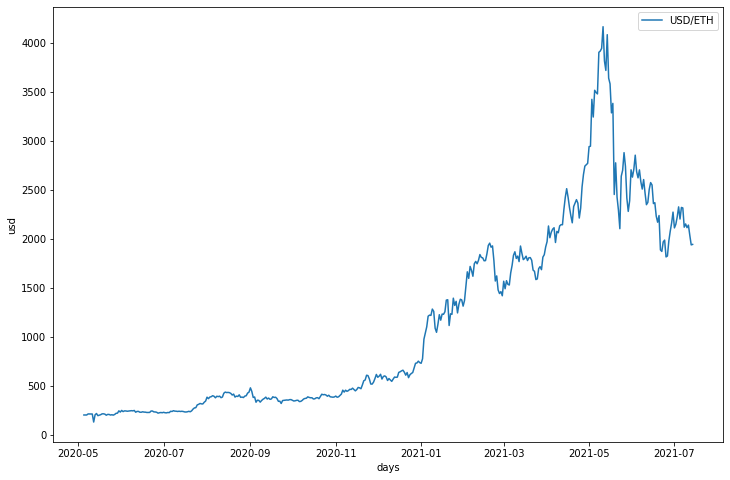

In [159]:
# Plot the data
f, ax = plt.subplots(1,1,figsize=(12,8))
ax.plot((arr[:,0]),arr[:,1], label='USD/ETH' )
ax.legend()
ax.set_xlabel('days')
ax.set_ylabel('usd')
#ax.set_yscale('log')

## Pandas

Now it's possible to import the (potentially large) array to Pandas for further work and analysis. Following are a few short examples of how to import the data as a Dataframe and a few other examples of what can be done.


In [160]:
# Pandas

import pandas as pd

df = pd.DataFrame(arr, columns=['Date','Price USD', 'Daily Vol USD', 'Daily Liquidity USD', 'Transactions'])

pd.set_option("display.max_rows", 10, "display.max_columns", None)
print(df)

          Date    Price USD     Daily Vol USD Daily Liquidity USD Transactions
0   2021-07-14   1943.83268  173356340.283626   1425442819.623755        49118
1   2021-07-13  1938.987847  235439580.254658   1426791185.721634        86550
2   2021-07-12  2035.935734  218112021.196549   1491979863.812764        84954
3   2021-07-11  2141.075595  174552040.998775   1580901277.826104        88696
4   2021-07-10  2115.008568  229467816.549082   1561535581.035897        94827
..         ...          ...               ...                 ...          ...
434 2020-05-08   212.096624               0.0           12.695072            8
435 2020-05-07   201.358662               0.0            2.097297            2
436 2020-05-06   201.358458          0.003059            2.097295            5
437 2020-05-05   201.486251          0.010931               0.989            3
438 2020-05-05   201.486251          0.010931               0.989            3

[439 rows x 5 columns]


In [175]:
# Basic information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 439 entries, 0 to 438
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Date                 439 non-null    datetime64[ns]
 1   Price USD            439 non-null    object        
 2   Daily Vol USD        439 non-null    object        
 3   Daily Liquidity USD  439 non-null    object        
 4   Transactions         439 non-null    object        
dtypes: datetime64[ns](1), object(4)
memory usage: 17.3+ KB


In [176]:
# Examples of queries
df['Daily Vol USD'].sum() #total volume

298492907573.3774

In [177]:
# What was the daily maximum volume?
df['Daily Vol USD'].max()

34119942201.871826

In [178]:
# Cumulative sum of transactions?
df['Transactions'].cumsum()

0         49118
1        135668
2        220622
3        309318
4        404145
         ...   
434    50913356
435    50913358
436    50913363
437    50913366
438    50913369
Name: Transactions, Length: 439, dtype: object